In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt
from openmm import app
import openmm as mm
from openmm import unit
import sys
import os

In [18]:
def reload(fname,T = 50, gamma = 1/50, length = 2, dt = 0.01, skipSteps = 1, 
           f_pdb = "pdb", f_ff = "forcefield", srSize = 10):
    #fname = "{}fs_{}ps_{}K_{}ss.xyz".format(dt, length, T, skipSteps)
    totSteps = int(length*1000/(skipSteps * dt))
    print("totSteps", totSteps)

    a = np.loadtxt(fname)
    nParticles = a.shape[-1]//3
    a = a.reshape(totSteps, 3, nParticles)
    print(a.shape)

    return a


In [21]:
def euclidean_distance(r1,r2):
    d = np.sqrt(
        np.sum(
            np.square(r1-r2)
        )
    )
    return d

def find_closest_monomer(p_small,p_large):
    n_small = np.shape(p_small)[0]
    n_large = np.shape(p_large)[0]

    distance_matrix = np.zeros((n_small,n_large))

    # Calculate the distance from each unit of the smaller ring to each unit on 
    # the longer ring
    for i in range(n_small):
        for j in range(n_large):
            r1 = p_small[i,:]
            r2 = p_large[j,:]
            distance_matrix[i,j]= euclidean_distance(r1,r2)

    #Return the distance 
    closest_monomer_to_each_bead = np.argmin(distance_matrix,axis=1)
    return closest_monomer_to_each_bead

def calculate_circle_center_of_mass(ring):
    return np.mean(ring,axis=0)

def calculate_vector_magnitude(v):
    return np.sqrt(np.sum(np.square(v)))

def calculate_angular_displacement():
   
    position_time_tensor =reload("0.01fs_2ps_1K_1ss.xyz")

    small_ring_carbon_indices=(0,20)
    large_ring_carbon_indices=(20,220)
    
    #Extract the small ring positions
    p_small = position_time_tensor[:,:,
                    small_ring_carbon_indices[0]:small_ring_carbon_indices[1]]
        
    #Extract the large ring positions
    p_large = position_time_tensor[:,:,
                    large_ring_carbon_indices[0]:large_ring_carbon_indices[1]]
    
    # Find the closest monomer to each bead for the initial position, 
    # transposing just to give the matrix the right shape 
    initial_closest_monomers_to_each_bead = find_closest_monomer(
        p_small[0,:,:].T,
        p_large[0,:,:].T
    )
    
    initial_index = int(np.mean(initial_closest_monomers_to_each_bead))
    
    nt = np.shape(position_time_tensor)[0]
    angular_displacement = np.zeros(nt)    

    # find the initial radius of the beads
    theta = 2*np.pi/p_large.shape[-1]
    
    for i in range(100):
        # find the angle within the plane of r_s_CoM and r_l_CoM for each node
        small_center = calculate_circle_center_of_mass(p_small[i,:,:].T)
        print(small_center)
        # find the current monomer index
        sm_mono_index = find_closest_monomer(np.array([small_center]), 
                                             p_large[i, :, :].T)
        
        # difference in index between init and current 
        delta = sm_mono_index - initial_index

        # angular distance according to the initial monomer geometry
        ang_disp = delta * theta

        angular_displacement[i] = ang_disp
        
    return angular_displacement

In [6]:
def runSim(T = 50, gamma = 1/50, length = 10, dt = 0.01, skipSteps = 1, f_pdb = "pdb", 
           f_ff = "forcefield", srSize = 20):
    """
    Function to run the openMM simulation (NVT) with given params and 
    pdb+forcefields

    Saves a xyz file of a compressed 3d array. See the function reload() to get 
    an idea of how to load and manipulate the output array (and format the file 
    name). The final array should have dims defined by 
    [n_timesteps, 3 (xyz), n_particles]

    parameters:
    T: int
        Temperature
    gamma: float
        Friction parameters for Langevin
    len: float
        Total length of the simulation in ps
    dt: float
        Size of the timesteps in ps
    f_pdb: str
        Name of the pdb file (excluding the file extension, which should 
        simply be .pdb)
    f_ff: str
        Name of the forcefield file (excluding the file extension, which should 
        simply be .xml)
    srSize: int
        Number of monomer units in the small ring
    """
    # set up strings
    # THE FOLLOWING FILE NAMES ARE PLACEHOLDERS: CHANGE WHEN POSSIBLE
    path = os.getcwd()
    pdbPath = os.path.join(path, "pdb_files/{}.pdb".format(f_pdb))
    forcefieldPath = os.path.join(path, "pdb_files/{}.xml".format(f_ff))

    # set up params
    kB = 1#1.38e-23
    beta = 1 # needs kb
    steps = int(length*1000/dt)
    indSteps = int(length*1000/(dt*skipSteps))

    # load external files for topo and PES
    pdb = app.PDBFile(pdbPath)
    topo = pdb.topology

    # identify atoms in topology
    particles = []
    # future update maybe: collect residues to identify number of atoms/chain
    # residues = []
    for atom in topo.atoms():
        particles.append(atom)
        # residues.append(atom.residue)

    # add bonds between the individual rings
    c1 = particles[0:srSize]
    c2 = particles[srSize:]
    numParticles = len(particles)
    # hy1 = particles[20:40]
    # hy2 = particles[40:60]

    # create arrays to store xyz coords in
    # format is timestep:xyz:particle#
    traj = np.zeros((indSteps, 3, numParticles))

    for i, C in enumerate(c1):
        topo.addBond(C, c1[i-1])
        # topo.addBond(C, hy1[i])
        # topo.addBond(C, hy2[i])
    
    for i, C in enumerate(c2):
        topo.addBond(C, c2[i-1])
        # topo.addBond(C, hy1[i])
        # topo.addBond(C, hy2[i])

    forcefield = app.ForceField(forcefieldPath)
    unmatched_residues = forcefield.getUnmatchedResidues(topo)
    print("unmatched residues\n", unmatched_residues)
    nonbonded = app.NoCutoff
         
    system = forcefield.createSystem(topo,constraints=None)

    integrator = mm.LangevinIntegrator(T*unit.kelvin, gamma, 
                                       dt*unit.femtoseconds)

    platform = mm.Platform.getPlatformByName('Reference')
    simulation = app.Simulation(pdb.topology, system, integrator, platform)
    simulation.context.setPositions(pdb.positions)
    simulation.context.computeVirtualSites()
    simulation.context.setVelocitiesToTemperature(T*unit.kelvin)

    # equilibration step
    # simulation.step(1000)

    for step in range(steps):
        simulation.step(skipSteps)
        # extract positions
        current = simulation.context.getState(getPositions = True)
        positions = np.array(current.getPositions()/unit.nanometer)
        traj[step, :, :] = positions.transpose()

    # save the trajectory as an xyz file
    traj_r = traj.reshape(traj.shape[0], -1)
    print(traj_r.shape)
    np.savetxt("{}fs_{}ps_{}K_{}ss.xyz".format(dt, length, T, skipSteps), traj_r)
    return traj_r

In [14]:
traj_r = runSim(
    T = 1, 
    gamma = 1/50, 
    length = 2, 
    dt = 0.01, 
    skipSteps = 1, 
    f_pdb = "combined_rings", 
    f_ff = "forcefield", 
    srSize = 10
)

unmatched residues
 []
(200000, 630)


totSteps 200000
(200000, 3, 210)
[ 9.39942099e+12 -4.37486995e+13 -6.01851609e-03]
[ 1.87988401e+13 -8.74973902e+13 -1.24890898e-02]
[ 2.81982573e+13 -1.31246072e+14  1.24248480e-02]
[ 3.75976727e+13 -1.74994745e+14 -2.51548087e-02]
[ 4.69970862e+13 -2.18743410e+14  2.47658395e-02]
[ 5.63964978e+13 -2.62492066e+14 -3.13497802e-04]
[ 6.57959075e+13 -3.06240713e+14 -3.14815251e-04]
[ 7.51953153e+13 -3.49989351e+14  4.96875826e-02]
[ 8.45947212e+13 -3.93737980e+14 -5.02318236e-02]
[ 9.39941253e+13 -4.37486601e+14 -5.03035442e-02]
[ 1.03393528e+14 -4.81235213e+14  4.94614442e-02]
[ 1.12792928e+14 -5.24983816e+14  4.92966759e-02]
[ 1.22192326e+14 -5.68732411e+14 -8.64747475e-04]
[ 1.31591723e+14 -6.12480997e+14 -8.69973463e-04]
[ 1.40991117e+14 -6.56229574e+14 -5.09457805e-02]
[ 1.50390510e+14 -6.99978142e+14 -1.10296762e-03]
[ 1.59789901e+14 -7.43726701e+14 -1.26403000e-03]
[ 1.69189290e+14 -7.87475252e+14 -1.34725788e-03]
[ 1.78588677e+14 -8.31223794e+14 -1.50479825e-03]
[ 1.87988063e+14 

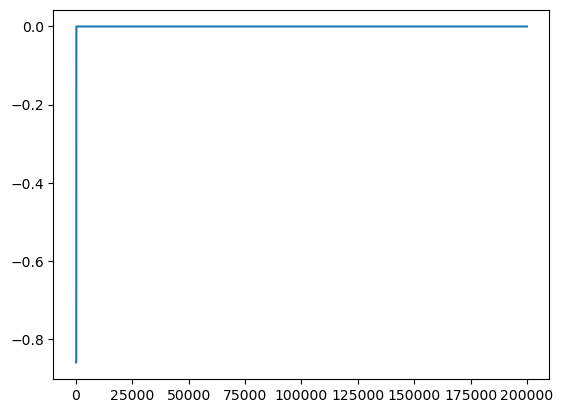

In [22]:
angs = calculate_angular_displacement()
iters = np.arange(angs.shape[0])
print("shape of angles:", angs.shape)
print("shape of iters:", iters.shape)
plt.plot(iters, angs)
plt.show()
plt.close()

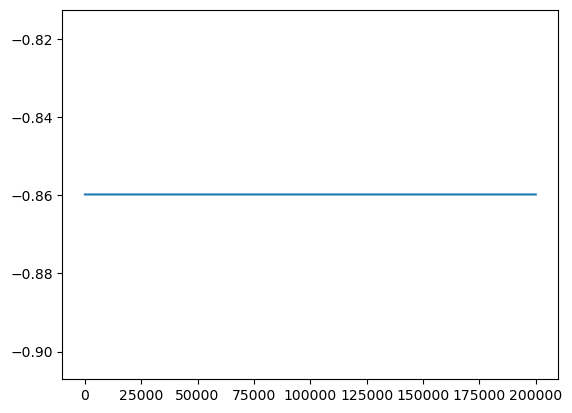

In [20]:
plt.figure()
plt.plot(iters, angs)
